# SYDE 411 Final Project

In [1]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple
import random
from copy import deepcopy

In [4]:
np.random.seed(42)
random.seed(42)

In [5]:
@dataclass
class Request:
    """Passenger request with arrival time, start floor, and destination floor"""
    id: int
    arrival_time: float
    start_floor: int
    dest_floor: int
    assigned_elevator: int = -1
    wait_time: float = 0.0
    service_time: float = 0.0


@dataclass
class Elevator:
    """Elevator with capacity, speed, and current state"""
    id: int
    capacity: int = 10
    speed: float = 1.5  # m/s
    door_time: float = 5.0  # seconds
    current_floor: int = 1
    current_time: float = 0.0
    passengers: List[Request] = None
    total_distance: float = 0.0
    
    def __post_init__(self):
        if self.passengers is None:
            self.passengers = []


In [8]:
class ElevatorSystem:
    """Main elevator system with scheduling strategies"""
    
    def __init__(self, num_floors=33, num_elevators=4, floor_height=3.0):
        self.num_floors = num_floors
        self.num_elevators = num_elevators
        self.floor_height = floor_height  # meters
        self.elevators = [Elevator(id=i, capacity=10, speed=1.5, door_time=5.0) 
                         for i in range(num_elevators)]
        self.requests = []
        
    def reset(self):
        """Reset elevator system to initial state"""
        self.elevators = [Elevator(id=i, capacity=10, speed=1.5, door_time=5.0) 
                         for i in range(self.num_elevators)]
        for req in self.requests:
            req.assigned_elevator = -1
            req.wait_time = 0.0
            req.service_time = 0.0
    
    def generate_requests(self, num_requests=100, time_period='peak'):
        """Generate random passenger requests"""
        self.requests = []
        
        for i in range(num_requests):
            if time_period == 'peak':
                # Morning rush: most people go from 1st floor upward
                arrival_time = np.random.exponential(2.0)
                start_floor = 1 if np.random.random() < 0.7 else np.random.randint(1, self.num_floors + 1)
                if start_floor == 1:
                    dest_floor = np.random.randint(2, self.num_floors + 1)
                else:
                    dest_floor = np.random.randint(1, self.num_floors + 1)
                    while dest_floor == start_floor:
                        dest_floor = np.random.randint(1, self.num_floors + 1)
            else:
                # Off-peak: random distribution
                arrival_time = np.random.exponential(5.0)
                start_floor = np.random.randint(1, self.num_floors + 1)
                dest_floor = np.random.randint(1, self.num_floors + 1)
                while dest_floor == start_floor:
                    dest_floor = np.random.randint(1, self.num_floors + 1)
            
            self.requests.append(Request(
                id=i,
                arrival_time=arrival_time,
                start_floor=start_floor,
                dest_floor=dest_floor
            ))
        
        self.requests.sort(key=lambda x: x.arrival_time)
    
    def calculate_travel_time(self, from_floor, to_floor, speed, door_time):
        """Calculate travel time between floors"""
        distance = abs(to_floor - from_floor) * self.floor_height
        travel_time = distance / speed + door_time
        return travel_time
    
    def fcfs_strategy(self):
        """First Come First Serve strategy"""
        self.reset()
        
        for request in self.requests:
            # Find closest available elevator
            min_time = float('inf')
            best_elevator = 0
            
            for elev in self.elevators:
                time_to_pickup = self.calculate_travel_time(
                    elev.current_floor, request.start_floor, 
                    elev.speed, elev.door_time
                )
                arrival_time = max(request.arrival_time, elev.current_time + time_to_pickup)
                
                if arrival_time < min_time:
                    min_time = arrival_time
                    best_elevator = elev.id
            
            # Assign request to best elevator
            elev = self.elevators[best_elevator]
            request.assigned_elevator = best_elevator
            
            # Calculate wait time
            time_to_pickup = self.calculate_travel_time(
                elev.current_floor, request.start_floor,
                elev.speed, elev.door_time
            )
            pickup_time = max(request.arrival_time, elev.current_time + time_to_pickup)
            request.wait_time = pickup_time - request.arrival_time
            
            # Calculate service time
            service_time = self.calculate_travel_time(
                request.start_floor, request.dest_floor,
                elev.speed, elev.door_time
            )
            request.service_time = service_time
            
            # Update elevator state
            elev.total_distance += abs(elev.current_floor - request.start_floor) * self.floor_height
            elev.total_distance += abs(request.start_floor - request.dest_floor) * self.floor_height
            elev.current_floor = request.dest_floor
            elev.current_time = pickup_time + service_time
        
        return self.calculate_metrics()
    
    def sstf_strategy(self):
        """Shortest Seek Time First strategy"""
        self.reset()
        remaining_requests = self.requests.copy()
        
        while remaining_requests:
            # For each elevator, find the closest request
            for elev in self.elevators:
                if not remaining_requests:
                    break
                
                # Find closest request that has arrived
                min_distance = float('inf')
                best_request = None
                
                for req in remaining_requests:
                    if req.arrival_time <= elev.current_time:
                        distance = abs(elev.current_floor - req.start_floor)
                        if distance < min_distance:
                            min_distance = distance
                            best_request = req
                
                # If no request has arrived yet, take the earliest one
                if best_request is None:
                    best_request = min(remaining_requests, key=lambda x: x.arrival_time)
                
                # Assign request
                best_request.assigned_elevator = elev.id
                
                # Calculate times
                time_to_pickup = self.calculate_travel_time(
                    elev.current_floor, best_request.start_floor,
                    elev.speed, elev.door_time
                )
                pickup_time = max(best_request.arrival_time, elev.current_time + time_to_pickup)
                best_request.wait_time = pickup_time - best_request.arrival_time
                
                service_time = self.calculate_travel_time(
                    best_request.start_floor, best_request.dest_floor,
                    elev.speed, elev.door_time
                )
                best_request.service_time = service_time
                
                # Update elevator
                elev.total_distance += abs(elev.current_floor - best_request.start_floor) * self.floor_height
                elev.total_distance += abs(best_request.start_floor - best_request.dest_floor) * self.floor_height
                elev.current_floor = best_request.dest_floor
                elev.current_time = pickup_time + service_time
                
                remaining_requests.remove(best_request)
        
        return self.calculate_metrics()
    
    def zoning_strategy(self):
        """Zoning strategy - divide building into zones"""
        self.reset()
        
        # Divide floors into zones
        floors_per_zone = self.num_floors // self.num_elevators
        zones = []
        for i in range(self.num_elevators):
            start = i * floors_per_zone + 1
            end = (i + 1) * floors_per_zone if i < self.num_elevators - 1 else self.num_floors
            zones.append((start, end))
        
        # Assign requests to zones based on start floor
        zone_requests = [[] for _ in range(self.num_elevators)]
        for req in self.requests:
            for i, (start, end) in enumerate(zones):
                if start <= req.start_floor <= end:
                    zone_requests[i].append(req)
                    break
        
        # Process each zone with FCFS
        for elev_id, requests in enumerate(zone_requests):
            elev = self.elevators[elev_id]
            for req in requests:
                req.assigned_elevator = elev_id
                
                time_to_pickup = self.calculate_travel_time(
                    elev.current_floor, req.start_floor,
                    elev.speed, elev.door_time
                )
                pickup_time = max(req.arrival_time, elev.current_time + time_to_pickup)
                req.wait_time = pickup_time - req.arrival_time
                
                service_time = self.calculate_travel_time(
                    req.start_floor, req.dest_floor,
                    elev.speed, elev.door_time
                )
                req.service_time = service_time
                
                elev.total_distance += abs(elev.current_floor - req.start_floor) * self.floor_height
                elev.total_distance += abs(req.start_floor - req.dest_floor) * self.floor_height
                elev.current_floor = req.dest_floor
                elev.current_time = pickup_time + service_time
        
        return self.calculate_metrics()
    
    def calculate_metrics(self):
        """Calculate performance metrics"""
        total_wait_time = sum(req.wait_time for req in self.requests)
        total_run_time = sum(elev.current_time for elev in self.elevators)
        total_distance = sum(elev.total_distance for elev in self.elevators)
        energy_consumption = total_distance * 0.05  # Simplified energy model (kWh)
        
        return {
            'total_wait_time': total_wait_time,
            'total_run_time': total_run_time,
            'energy_consumption': energy_consumption,
            'avg_wait_time': total_wait_time / len(self.requests),
            'max_wait_time': max(req.wait_time for req in self.requests)
        }


In [6]:
class GeneticAlgorithm:
    """Genetic Algorithm for elevator scheduling optimization"""
    
    def __init__(self, elevator_system, population_size=50, generations=100, 
                 mutation_rate=0.1, crossover_rate=0.8, alpha=0.5):
        self.system = elevator_system
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.alpha = alpha  # Weight for wait time vs run time
        
    def encode_chromosome(self):
        """Create a random chromosome (assignment of requests to elevators)"""
        chromosome = [random.randint(0, self.system.num_elevators - 1) 
                     for _ in range(len(self.system.requests))]
        return chromosome
    
    def decode_and_evaluate(self, chromosome):
        """Evaluate fitness of a chromosome"""
        self.system.reset()
        
        # Assign requests according to chromosome
        for req, elev_id in zip(self.system.requests, chromosome):
            req.assigned_elevator = elev_id
        
        # Simulate elevator operation
        for elev in self.system.elevators:
            elev_requests = [req for req in self.system.requests 
                           if req.assigned_elevator == elev.id]
            elev_requests.sort(key=lambda x: x.arrival_time)
            
            for req in elev_requests:
                time_to_pickup = self.system.calculate_travel_time(
                    elev.current_floor, req.start_floor,
                    elev.speed, elev.door_time
                )
                pickup_time = max(req.arrival_time, elev.current_time + time_to_pickup)
                req.wait_time = pickup_time - req.arrival_time
                
                service_time = self.system.calculate_travel_time(
                    req.start_floor, req.dest_floor,
                    elev.speed, elev.door_time
                )
                req.service_time = service_time
                
                elev.total_distance += abs(elev.current_floor - req.start_floor) * self.system.floor_height
                elev.total_distance += abs(req.start_floor - req.dest_floor) * self.system.floor_height
                elev.current_floor = req.dest_floor
                elev.current_time = pickup_time + service_time
        
        metrics = self.system.calculate_metrics()
        # Fitness: weighted sum of normalized wait time and run time
        fitness = (self.alpha * metrics['total_wait_time'] + 
                  (1 - self.alpha) * metrics['total_run_time'])
        return fitness
    
    def tournament_selection(self, population, fitnesses, tournament_size=3):
        """Tournament selection"""
        selected = []
        for _ in range(len(population)):
            tournament = random.sample(list(zip(population, fitnesses)), tournament_size)
            winner = min(tournament, key=lambda x: x[1])[0]
            selected.append(winner.copy())
        return selected
    
    def crossover(self, parent1, parent2):
        """Single-point crossover"""
        if random.random() < self.crossover_rate:
            point = random.randint(1, len(parent1) - 1)
            child1 = parent1[:point] + parent2[point:]
            child2 = parent2[:point] + parent1[point:]
            return child1, child2
        return parent1.copy(), parent2.copy()
    
    def mutate(self, chromosome):
        """Random mutation"""
        mutated = chromosome.copy()
        for i in range(len(mutated)):
            if random.random() < self.mutation_rate:
                mutated[i] = random.randint(0, self.system.num_elevators - 1)
        return mutated
    
    def optimize(self):
        """Run genetic algorithm"""
        # Initialize population
        population = [self.encode_chromosome() for _ in range(self.population_size)]
        
        best_fitness_history = []
        avg_fitness_history = []
        
        for generation in range(self.generations):
            # Evaluate fitness
            fitnesses = [self.decode_and_evaluate(chrom) for chrom in population]
            
            # Track best solution
            best_idx = np.argmin(fitnesses)
            best_fitness = fitnesses[best_idx]
            best_fitness_history.append(best_fitness)
            avg_fitness_history.append(np.mean(fitnesses))
            
            if generation % 20 == 0:
                print(f"Generation {generation}: Best Fitness = {best_fitness:.2f}, "
                      f"Avg Fitness = {np.mean(fitnesses):.2f}")
            
            # Selection
            population = self.tournament_selection(population, fitnesses)
            
            # Crossover
            new_population = []
            for i in range(0, len(population), 2):
                if i + 1 < len(population):
                    child1, child2 = self.crossover(population[i], population[i + 1])
                    new_population.extend([child1, child2])
                else:
                    new_population.append(population[i])
            
            # Mutation
            population = [self.mutate(chrom) for chrom in new_population]
        
        # Final evaluation
        fitnesses = [self.decode_and_evaluate(chrom) for chrom in population]
        best_idx = np.argmin(fitnesses)
        best_chromosome = population[best_idx]
        
        # Apply best solution
        self.decode_and_evaluate(best_chromosome)
        metrics = self.system.calculate_metrics()
        
        return metrics, best_fitness_history, avg_fitness_history


In [9]:
# Initialize system
system = ElevatorSystem(num_floors=33, num_elevators=4)
system.generate_requests(num_requests=100, time_period='peak')

print(f"\nSimulation Setup:")
print(f"- Building: {system.num_floors} floors")
print(f"- Elevators: {system.num_elevators}")
print(f"- Passenger requests: {len(system.requests)}")
print(f"- Elevator capacity: 10 passengers")
print(f"- Elevator speed: 1.5 m/s")
print(f"- Door time: 5 seconds")



Simulation Setup:
- Building: 33 floors
- Elevators: 4
- Passenger requests: 100
- Elevator capacity: 10 passengers
- Elevator speed: 1.5 m/s
- Door time: 5 seconds


In [10]:
results = {}

print("\n" + "=" * 60)
print("Testing FCFS Strategy...")
results['FCFS'] = system.fcfs_strategy()
print(f"Total Wait Time: {results['FCFS']['total_wait_time']:.2f} seconds")
print(f"Total Run Time: {results['FCFS']['total_run_time']:.2f} seconds")
print(f"Energy Consumption: {results['FCFS']['energy_consumption']:.2f} kWh")

print("\n" + "=" * 60)
print("Testing SSTF Strategy...")
results['SSTF'] = system.sstf_strategy()
print(f"Total Wait Time: {results['SSTF']['total_wait_time']:.2f} seconds")
print(f"Total Run Time: {results['SSTF']['total_run_time']:.2f} seconds")
print(f"Energy Consumption: {results['SSTF']['energy_consumption']:.2f} kWh")

print("\n" + "=" * 60)
print("Testing Zoning Strategy...")
results['Zoning'] = system.zoning_strategy()
print(f"Total Wait Time: {results['Zoning']['total_wait_time']:.2f} seconds")
print(f"Total Run Time: {results['Zoning']['total_run_time']:.2f} seconds")
print(f"Energy Consumption: {results['Zoning']['energy_consumption']:.2f} kWh")

print("\n" + "=" * 60)
print("Testing Genetic Algorithm Optimization...")
ga = GeneticAlgorithm(system, population_size=50, generations=100, 
                     mutation_rate=0.1, crossover_rate=0.8, alpha=0.5)
results['GA'], best_history, avg_history = ga.optimize()
print(f"\nFinal Results:")
print(f"Total Wait Time: {results['GA']['total_wait_time']:.2f} seconds")
print(f"Total Run Time: {results['GA']['total_run_time']:.2f} seconds")
print(f"Energy Consumption: {results['GA']['energy_consumption']:.2f} kWh")



Testing FCFS Strategy...
Total Wait Time: 79777.80 seconds
Total Run Time: 6680.00 seconds
Energy Consumption: 426.00 kWh

Testing SSTF Strategy...
Total Wait Time: 73067.80 seconds
Total Run Time: 6676.00 seconds
Energy Consumption: 425.70 kWh

Testing Zoning Strategy...
Total Wait Time: 257603.80 seconds
Total Run Time: 7368.00 seconds
Energy Consumption: 477.60 kWh

Testing Genetic Algorithm Optimization...
Generation 0: Best Fitness = 46126.90, Avg Fitness = 49163.94
Generation 20: Best Fitness = 43270.90, Avg Fitness = 45417.62
Generation 40: Best Fitness = 44198.90, Avg Fitness = 46127.94
Generation 60: Best Fitness = 44157.90, Avg Fitness = 46246.76
Generation 80: Best Fitness = 43393.90, Avg Fitness = 46156.32

Final Results:
Total Wait Time: 80381.80 seconds
Total Run Time: 6872.00 seconds
Energy Consumption: 440.40 kWh


In [11]:
print("\n" + "=" * 60)
print("Performance Comparison")
print("=" * 60)

df = pd.DataFrame({
    'Strategy': ['FCFS', 'SSTF', 'Zoning', 'GA'],
    'Total Run Time (s)': [results[s]['total_run_time'] for s in ['FCFS', 'SSTF', 'Zoning', 'GA']],
    'Total Wait Time (s)': [results[s]['total_wait_time'] for s in ['FCFS', 'SSTF', 'Zoning', 'GA']],
    'Energy (kWh)': [results[s]['energy_consumption'] for s in ['FCFS', 'SSTF', 'Zoning', 'GA']],
    'Avg Wait Time (s)': [results[s]['avg_wait_time'] for s in ['FCFS', 'SSTF', 'Zoning', 'GA']]
})
print(df.to_string(index=False))



Performance Comparison
Strategy  Total Run Time (s)  Total Wait Time (s)  Energy (kWh)  Avg Wait Time (s)
    FCFS              6680.0         79777.803198         426.0         797.778032
    SSTF              6676.0         73067.803198         425.7         730.678032
  Zoning              7368.0        257603.803198         477.6        2576.038032
      GA              6872.0         80381.803198         440.4         803.818032



✓ Visualization saved as 'elevator_optimization_results.png'


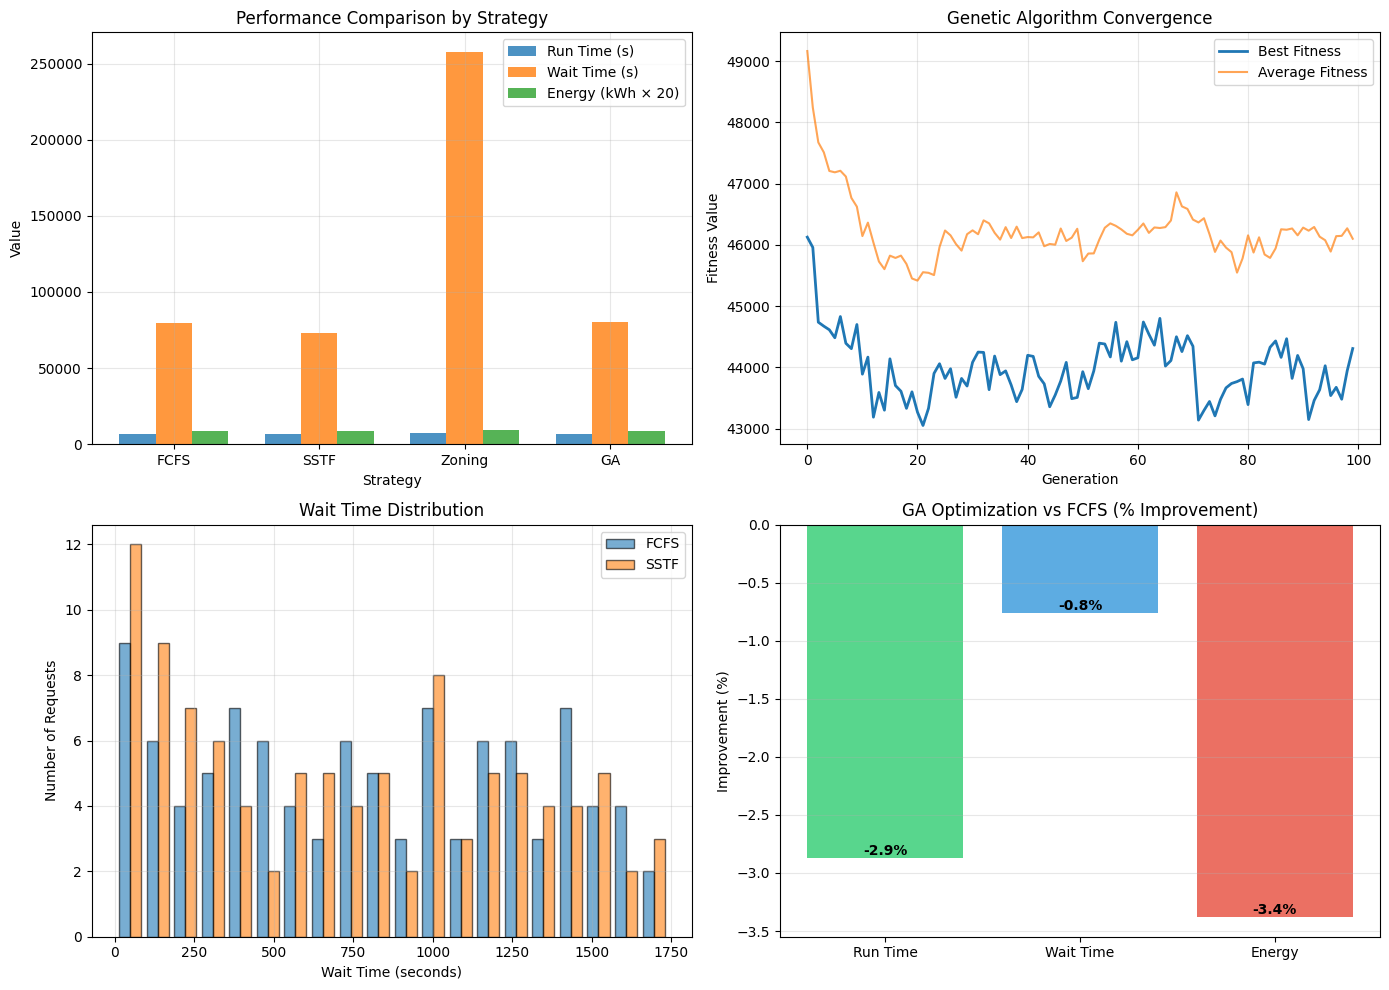

In [13]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Comparison bar chart
strategies = ['FCFS', 'SSTF', 'Zoning', 'GA']
x = np.arange(len(strategies))
width = 0.25

ax1 = axes[0, 0]
ax1.bar(x - width, [results[s]['total_run_time'] for s in strategies], 
        width, label='Run Time (s)', alpha=0.8)
ax1.bar(x, [results[s]['total_wait_time'] for s in strategies], 
        width, label='Wait Time (s)', alpha=0.8)
ax1.bar(x + width, [results[s]['energy_consumption'] * 20 for s in strategies], 
        width, label='Energy (kWh × 20)', alpha=0.8)
ax1.set_xlabel('Strategy')
ax1.set_ylabel('Value')
ax1.set_title('Performance Comparison by Strategy')
ax1.set_xticks(x)
ax1.set_xticklabels(strategies)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. GA convergence
ax2 = axes[0, 1]
ax2.plot(best_history, label='Best Fitness', linewidth=2)
ax2.plot(avg_history, label='Average Fitness', alpha=0.7)
ax2.set_xlabel('Generation')
ax2.set_ylabel('Fitness Value')
ax2.set_title('Genetic Algorithm Convergence')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Wait time distribution
ax3 = axes[1, 0]
wait_times_by_strategy = {
    'FCFS': [req.wait_time for req in system.requests],
}
# Re-run to get wait times for visualization
system.fcfs_strategy()
fcfs_waits = [req.wait_time for req in system.requests]
system.sstf_strategy()
sstf_waits = [req.wait_time for req in system.requests]

ax3.hist([fcfs_waits, sstf_waits], label=['FCFS', 'SSTF'], 
         bins=20, alpha=0.6, edgecolor='black')
ax3.set_xlabel('Wait Time (seconds)')
ax3.set_ylabel('Number of Requests')
ax3.set_title('Wait Time Distribution')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Improvement percentages
ax4 = axes[1, 1]
improvements = {
    'Run Time': (1 - results['GA']['total_run_time'] / results['FCFS']['total_run_time']) * 100,
    'Wait Time': (1 - results['GA']['total_wait_time'] / results['FCFS']['total_wait_time']) * 100,
    'Energy': (1 - results['GA']['energy_consumption'] / results['FCFS']['energy_consumption']) * 100
}
bars = ax4.bar(improvements.keys(), improvements.values(), 
               color=['#2ecc71', '#3498db', '#e74c3c'], alpha=0.8)
ax4.set_ylabel('Improvement (%)')
ax4.set_title('GA Optimization vs FCFS (% Improvement)')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('elevator_optimization_results.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved as 'elevator_optimization_results.png'")
plt.show()